#Example 1: Running a functional neural network with MAML

##Ed Pyzer-Knapp

In this example, we will go through in detail how a neural network is implemented, through examining the functional neural network which we have implemented in MAML.

###Step 1. Importing required modules

We need some standard python modules to perform the setup of the network (for example reading in features), and we need to import the network pieces themselves from the MAML package

In [4]:
import hickle as hkl #Used for reading in the data
import pickle as pkl #Used for saving the trained network and the output
import sklearn.cross_validation as cv #For splitting the training and testing data
import numpy as np #Used to create arrays for feeding into the network
from maml import neural_networks as nn #This contains all the network pieces

###Step 2. Reading in the data set

We of course need some data to train on.  We will use the example data included in maml, which is provided as a hickle file.  This will unpack to a dictionary with the following keys:

* '1024_morgans_r2' --> Inputs, radius 2 morgan circular fingerprints (from the RDKit) as bitvectors of length 1024
* 'homos' --> HOMO energies of the lowest energy conformer of the molecule calculated as BP86/def2-SVP
* 'lumos' --> LUMO energies of the lowest energy conformer of the molecule calculated as BP86/def2-SVP
* 'pces' --> Power Conversion Efficiencies of the lowest energy conformer of the molecules calculated using the Scharber Model

In [2]:
data = hkl.load('data/func_nn_example_data.hkl')

The inputs (X) are the morgan circular fingerprints

In [3]:
X = data['1024_morgans_r2']

The ouputs are the HOMO, LUMO and PCE values.  We will train against them all at the same time, since this will produce a more robust network.  This is because it is much harder to simultaneously overfit for three variables at the same time.

In [5]:
Y = np.array([data[t] for t in ['homos','lumos', 'pces']]).T

###Step 3. Normalizing the targets

It is generally considered a good idea to normalize the target values to have a 0 mean and unit standard deviation when training a neural network.  If you have a collection of features which are of different magnitudes, you can also scale these the same way to ensure that no one feature dominates just due to the units is is reported in.  Since our targets are bitvectors (0s and 1s) it is not necessary for us to do that here.

In [6]:
Y_mean = np.mean(Y)
Y_std = np.std(Y)
Y = (Y - Y_mean) / Y_std

###Step 4. Splitting the data into training and testing

In addition to training the network, we need some data to test the trained network on. We will use the useful train_test_split tool in the sklearn cross_validation module. The seed can be set to make sure that the sets are the same, or not set to create new training and validation sets each time.  We will try an 80/20 split here, although feel free to change this and see how it affects the results! 

In [7]:
X_train, X_test, Y_train, Y_test = cv.train_test_split(X, Y, test_size=0.2, random_state=99)

###Step 5. Performing the training

This is actually very easy in MAML! We have implemented a 'train' function which does all of the heavy lifting.  If you want more information as to how this works, look at the next tutorial in which we delve a little deeper into how the functional neural network works. 

To call 'train',we must specify a couple of parameters:

* X_train,X_test,Y_train,Y_test
* The number of nodes in each hidden layer (list)
* The activation function (tanh or logistic)
* The starting learn rate
* The number of epochs
* The number of cores to use for training
* The threshold for early termination.

In [8]:
nnet = nn.train(X_train,X_test,Y_train,Y_test,[32],'logistic',learn_rate=0.002,
                n_epochs=1000,n_cores=1, threshold=0.1)                                   

0 [ 0.79749587  0.53260267  3.37609539]
50 [ 0.00213001  0.00315088  0.36682794]
100 [ 0.00050124  0.00126874  0.35863491]
150 [  1.57737834e-04   6.11104626e-04   3.72321370e-01]
200 [  1.75214132e-04   3.27035128e-04   3.93069112e-01]
250 [  2.43124032e-04   1.24171529e-04   3.70358270e-01]
300 [  2.01850627e-04   2.98118590e-04   3.67640105e-01]
350 [  2.55262036e-04   1.95335956e-04   3.76604351e-01]
400 [  2.68716662e-04   2.15912421e-04   3.68003899e-01]
450 [  2.88656431e-04   1.76687874e-04   3.68679410e-01]
500 [  3.01474854e-04   4.32689776e-04   3.68858769e-01]
550 [  2.72500132e-04   3.77211997e-04   3.68646150e-01]
600 [  2.38099979e-04   2.74094398e-04   3.72682428e-01]
650 [  2.21818122e-04   2.29430209e-04   3.69298038e-01]
700 [  2.73774956e-04   2.04272551e-04   3.71793863e-01]
750 [  2.24405250e-04   2.24031622e-04   3.77737747e-01]
800 [  2.89236600e-04   4.08214924e-04   3.76288586e-01]
850 [  2.36223338e-04   3.33150015e-04   3.74889492e-01]


### Step 6. Testing the network on the validation set

Since the network has been trained on a large set of molecules, there is a chance that it has learned, in addition to a QSPR, the noise which is in that set.  This is known as overfitting. In order to test this, we must provide an external set of molecules which the network has not seen before.  Luckily we have such a set -- we made it in Step 4! We also need to remember to 'undo' the normalization we did in Step 3.

In [9]:
prediction = nn.output(X_test, nnet)

In [11]:
prediction = (Y_std * prediction) + Y_mean

In [12]:
Y_test = (Y_test * Y_std) + Y_mean

In [13]:
error = prediction - Y_test

In [17]:
MAE = np.mean(np.abs(error), axis=0)
print MAE

[ 0.02616814  0.03072193  0.70327553]


###Step 7. Plotting the results

It is nice to have a plot of the results to get an intuition about the success of the training.  We will use the jointplot in the Seaborn package to plot here, with density estimated using a KDE.  Here we will only plot the PCE performance, but you can easily change this to plot the other properties too!

In [18]:
import pylab as pl
import pandas as pd
import seaborn as sns

In [19]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [20]:
sns.set_style('white')
sns.set_context('poster')

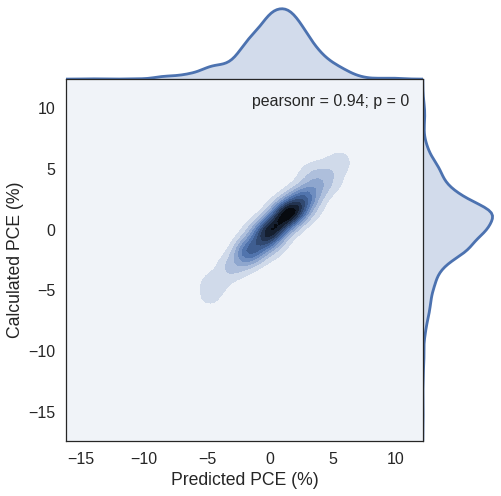

In [23]:
x1 = pd.Series(np.array([x[2] for x in prediction]), name='Predicted PCE (%)')
x2 = pd.Series(np.array([x[2] for x in Y_test]), name='Calculated PCE (%)')

g = sns.jointplot(x1, x2, kind='kde', size=7, space=0)


###Step 7. Saving the network for later use

If you want to use this network again, it is important to save it to a file.  We use pickle for this, since it is easy to restore this as an object in python.

In [16]:
with open('trained_network.pkl', 'w') as fp:
    pkl.dump(nnet, fp)